<a href="https://colab.research.google.com/github/maclandrol/cours-ia-med/blob/master/04_Classification_Texte_Medical_Francais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Classification de Textes Médicaux en Français

**Enseignant:** Emmanuel Noutahi, PhD

---

**Objectif:** Maîtriser la classification automatique de textes médicaux français avec des modèles de langage spécialisés.

**Applications pratiques :**
- Classification automatique de questions d'examens médicaux
- Analyse de comptes-rendus médicaux français
- Aide à la préparation d'examens de spécialisation
- Triage automatique de documents médicaux

**Dataset:** FrenchMedMCQA - 3,105 questions d'examens de pharmacie français avec réponses multiples.

**Important:** Ce cours utilise des données réelles d'examens médicaux français pour un apprentissage pratique.

## Installation et Configuration

In [1]:
# Installation des bibliothèques pour NLP médical français
!pip install transformers torch accelerate -q
!pip install "datasets<4.0.0"

!pip install scikit-learn pandas numpy matplotlib seaborn -q
!pip install huggingface_hub tokenizers -q


In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, pipeline
)

In [3]:
from sklearn.metrics import (
    classification_report, multilabel_confusion_matrix,
    accuracy_score, precision_recall_fscore_support,
    hamming_loss, jaccard_score
)
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')

# Configuration pour reproductibilité
torch.manual_seed(42)
np.random.seed(42)

# Détection du dispositif
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CPU only")

GPU: Tesla T4


## 1. Exploration du Dataset FrenchMedMCQA

Le dataset FrenchMedMCQA contient 3,105 questions d'examens de pharmacie français avec réponses multiples, représentant un défi réaliste de classification multi-label.

In [4]:
# Chargement depuis HuggingFace Hub
dataset = load_dataset("qanastek/frenchmedmcqa")
print("Dataset chargé avec succès depuis HuggingFace Hub")
print(f"Splits disponibles: {list(dataset.keys())}")

# Affichage de la structure
train_dataset = dataset['train']
print(f"\nTaille du dataset d'entraînement: {len(train_dataset)}")
print(f"Colonnes disponibles: {train_dataset.column_names}")

# Exploration d'un exemple
example = train_dataset[0]
print(f"\nExemple d'entrée:")
for key, value in example.items():
    print(f"  {key}: {type(value)} - {str(value)[:100]}..." if len(str(value)) > 100 else f"  {key}: {value}")

The repository for qanastek/frenchmedmcqa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/qanastek/frenchmedmcqa.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


DEFT-2023-FULL.zip:   0%|          | 0.00/550k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset chargé avec succès depuis HuggingFace Hub
Splits disponibles: ['train', 'validation', 'test']

Taille du dataset d'entraînement: 2171
Colonnes disponibles: ['id', 'question', 'answer_a', 'answer_b', 'answer_c', 'answer_d', 'answer_e', 'correct_answers', 'number_correct_answers']

Exemple d'entrée:
  id: 230bac49b0fe863b772410bc8d01a025f63c3c999065480131d6334abd2efeff
  question: Parmi les affirmations suivantes, une seule est fausse, indiquer laquelle: les particules alpha
  answer_a: Sont formées de noyaux d'hélium
  answer_b: Sont peu pénétrantes
  answer_c: <class 'str'> - Toute l'énergie qu'elles transportent est cédée au long d'un parcours de quelques centimètres dans l...
  answer_d: Sont arrêtées par une feuille de papier
  answer_e: Sont peu ionisantes
  correct_answers: [4]
  number_correct_answers: 0


=== ANALYSE EXPLORATOIRE ===
Nombre total de questions: 2171

Statistiques des questions:
Longueur moyenne: 99.6 caractères
Nombre moyen de mots: 13.7
Question la plus courte: 7 caractères
Question la plus longue: 491 caractères

Analyse des réponses:
Questions à réponse unique: 595 (27.4%)
Questions à réponses multiples: 1576 (72.6%)
Nombre moyen de réponses correctes: 2.38


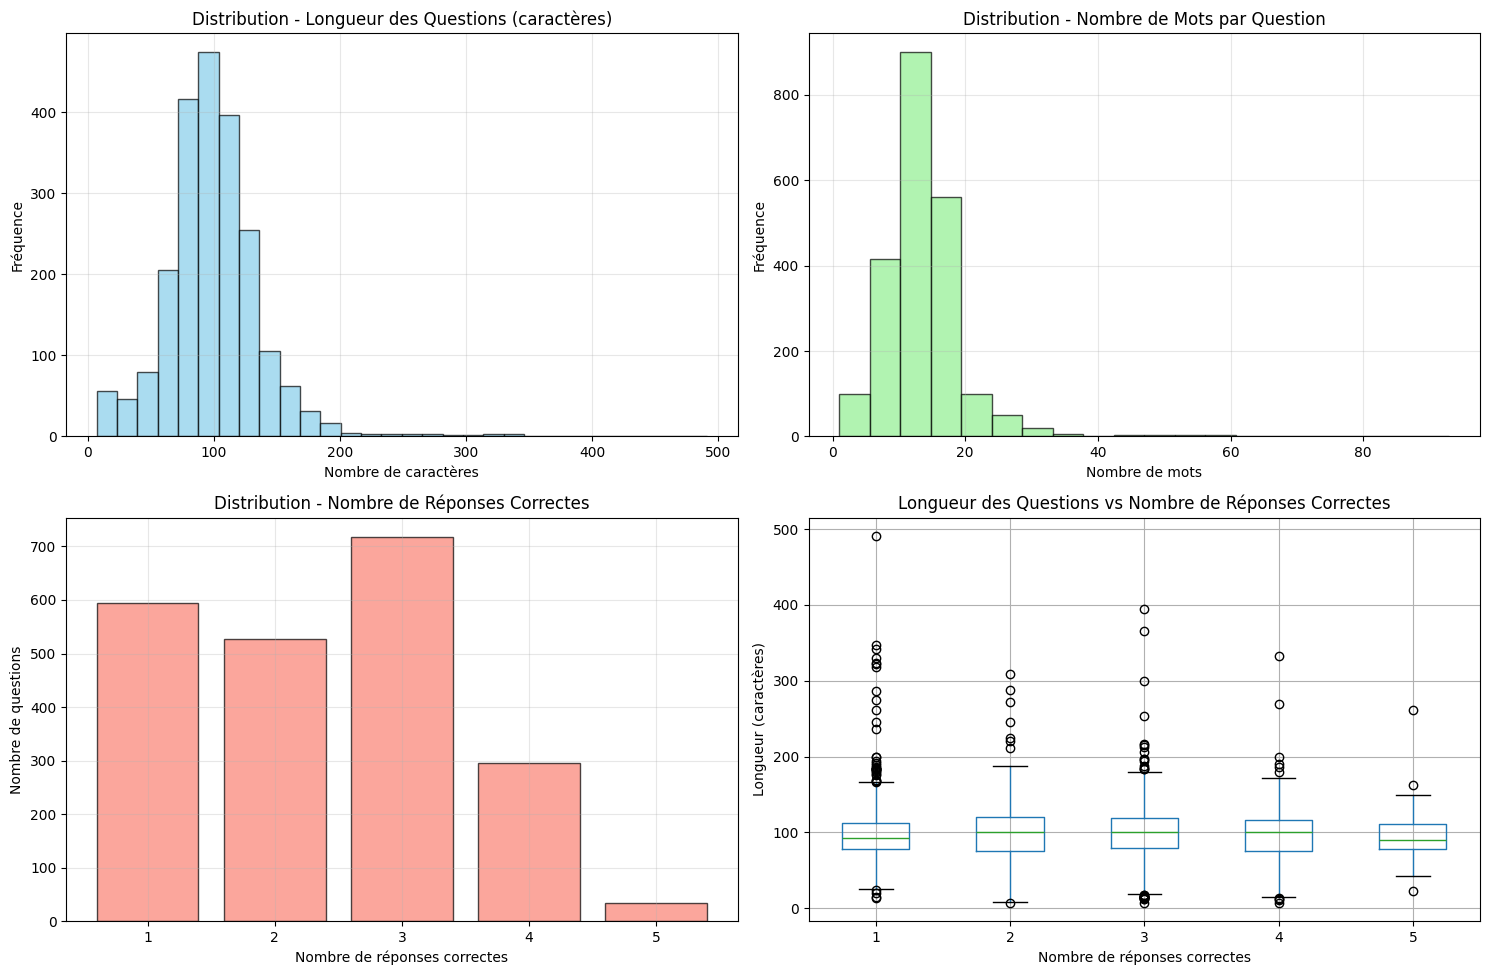

In [5]:
# Analyse exploratoire du dataset
print("=== ANALYSE EXPLORATOIRE ===")

# Conversion en DataFrame pour analyse
df = train_dataset.to_pandas()
print(f"Nombre total de questions: {len(df)}")

# Analyse de la longueur des questions
df['question_length'] = df['question'].str.len()
df['question_words'] = df['question'].str.split().str.len()

print(f"\nStatistiques des questions:")
print(f"Longueur moyenne: {df['question_length'].mean():.1f} caractères")
print(f"Nombre moyen de mots: {df['question_words'].mean():.1f}")
print(f"Question la plus courte: {df['question_length'].min()} caractères")
print(f"Question la plus longue: {df['question_length'].max()} caractères")

# Analyse des réponses correctes
df['num_correct_answers'] = df['correct_answers'].apply(len)

print(f"\nAnalyse des réponses:")
print(f"Questions à réponse unique: {sum(df['num_correct_answers'] == 1)} ({sum(df['num_correct_answers'] == 1)/len(df)*100:.1f}%)")
print(f"Questions à réponses multiples: {sum(df['num_correct_answers'] > 1)} ({sum(df['num_correct_answers'] > 1)/len(df)*100:.1f}%)")
print(f"Nombre moyen de réponses correctes: {df['num_correct_answers'].mean():.2f}")

# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Analyse Exploratoire - FrenchMedMCQA', fontsize=16, fontweight='bold')

# Distribution de la longueur des questions
axes[0, 0].hist(df['question_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution - Longueur des Questions (caractères)')
axes[0, 0].set_xlabel('Nombre de caractères')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].grid(True, alpha=0.3)

# Distribution du nombre de mots
axes[0, 1].hist(df['question_words'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Distribution - Nombre de Mots par Question')
axes[0, 1].set_xlabel('Nombre de mots')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].grid(True, alpha=0.3)

# Distribution du nombre de réponses correctes
answer_counts = df['num_correct_answers'].value_counts().sort_index()
axes[1, 0].bar(answer_counts.index, answer_counts.values, alpha=0.7, color='salmon', edgecolor='black')
axes[1, 0].set_title('Distribution - Nombre de Réponses Correctes')
axes[1, 0].set_xlabel('Nombre de réponses correctes')
axes[1, 0].set_ylabel('Nombre de questions')
axes[1, 0].grid(True, alpha=0.3)

# Boxplot longueur vs nombre de réponses
df.boxplot(column='question_length', by='num_correct_answers', ax=axes[1, 1])
axes[1, 1].set_title('Longueur des Questions vs Nombre de Réponses Correctes')
axes[1, 1].set_xlabel('Nombre de réponses correctes')
axes[1, 1].set_ylabel('Longueur (caractères)')

plt.suptitle('')  # Remove automatic title
plt.tight_layout()
plt.show()

In [6]:
! pip install wordcloud

## 2. Préparation des Données pour Classification Multi-label

Le dataset FrenchMedMCQA nécessite une approche de classification multi-label car les questions peuvent avoir plusieurs réponses correctes.

In [10]:
from collections import Counter

In [12]:
# Préparation pour classification multi-label
print("=== PRÉPARATION CLASSIFICATION MULTI-LABEL ===")

def prepare_multilabel_data(dataset_df):
    """
    Prépare les données pour classification multi-label
    """
    # Construction des questions complètes avec options
    questions_with_options = []
    labels = []

    for _, row in dataset_df.iterrows():
        # Construction de la question complète
        question_text = f"{row['question']}\n"
        question_text += f"A) {row['answer_a']}\n"
        question_text += f"B) {row['answer_b']}\n"
        question_text += f"C) {row['answer_c']}\n"
        question_text += f"D) {row['answer_d']}\n"
        question_text += f"E) {row['answer_e']}"

        questions_with_options.append(question_text)

        # Conversion des réponses correctes en format multi-label binaire
        label_vector = [0] * 5  # 5 options (A, B, C, D, E)
        for correct_idx in row['correct_answers']:
            if 0 <= correct_idx <= 4:
                label_vector[correct_idx] = 1

        labels.append(label_vector)

    return questions_with_options, labels

# Préparation des données
texts, labels = prepare_multilabel_data(df)

print(f"Nombre d'exemples préparés: {len(texts)}")
print(f"Format des labels: {len(labels[0])} classes (A, B, C, D, E)")

# Exemple d'entrée préparée
print(f"\nExemple d'entrée préparée:")
print(f"Texte: {texts[0][:200]}...")
print(f"Labels: {labels[0]} (positions des réponses correctes)")

# Statistiques des labels
labels_array = np.array(labels)
print(f"\nStatistiques des labels:")
print(f"Nombre moyen de labels par question: {labels_array.sum(axis=1).mean():.2f}")
print(f"Distribution des réponses correctes par option:")

option_names = ['A', 'B', 'C', 'D', 'E']
for i, option in enumerate(option_names):
    count = labels_array[:, i].sum()
    percentage = (count / len(labels)) * 100
    print(f"  Option {option}: {count} ({percentage:.1f}%)")

# Analyse de la distribution multi-label
label_combinations = []
for label in labels:
    # Création d'une chaîne représentant la combinaison
    combination = ''.join([option_names[i] for i, val in enumerate(label) if val == 1])
    label_combinations.append(combination)

combination_counts = Counter(label_combinations)
print(f"\nCombinaisons de réponses les plus fréquentes:")
for combination, count in combination_counts.most_common(10):
    percentage = (count / len(label_combinations)) * 100
    print(f"  {combination if combination else 'Aucune'}: {count} ({percentage:.1f}%)")

=== PRÉPARATION CLASSIFICATION MULTI-LABEL ===
Nombre d'exemples préparés: 2171
Format des labels: 5 classes (A, B, C, D, E)

Exemple d'entrée préparée:
Texte: Parmi les affirmations suivantes, une seule est fausse, indiquer laquelle: les particules alpha
A) Sont formées de noyaux d'hélium
B) Sont peu pénétrantes
C) Toute l'énergie qu'elles transportent est ...
Labels: [0, 0, 0, 0, 1] (positions des réponses correctes)

Statistiques des labels:
Nombre moyen de labels par question: 2.38
Distribution des réponses correctes par option:
  Option A: 1038 (47.8%)
  Option B: 1069 (49.2%)
  Option C: 1063 (49.0%)
  Option D: 1066 (49.1%)
  Option E: 923 (42.5%)

Combinaisons de réponses les plus fréquentes:
  D: 156 (7.2%)
  C: 142 (6.5%)
  B: 119 (5.5%)
  A: 94 (4.3%)
  ACE: 86 (4.0%)
  E: 84 (3.9%)
  BCD: 82 (3.8%)
  ACD: 82 (3.8%)
  ABDE: 81 (3.7%)
  ABC: 79 (3.6%)


=== DIVISION DES DONNÉES ===
Données d'entraînement: 1736 exemples
Données de validation: 217 exemples
Données de test: 218 exemples

Vérification stratification:
Train - moyenne labels/question: 2.38
Validation - moyenne labels/question: 2.38
Test - moyenne labels/question: 2.37


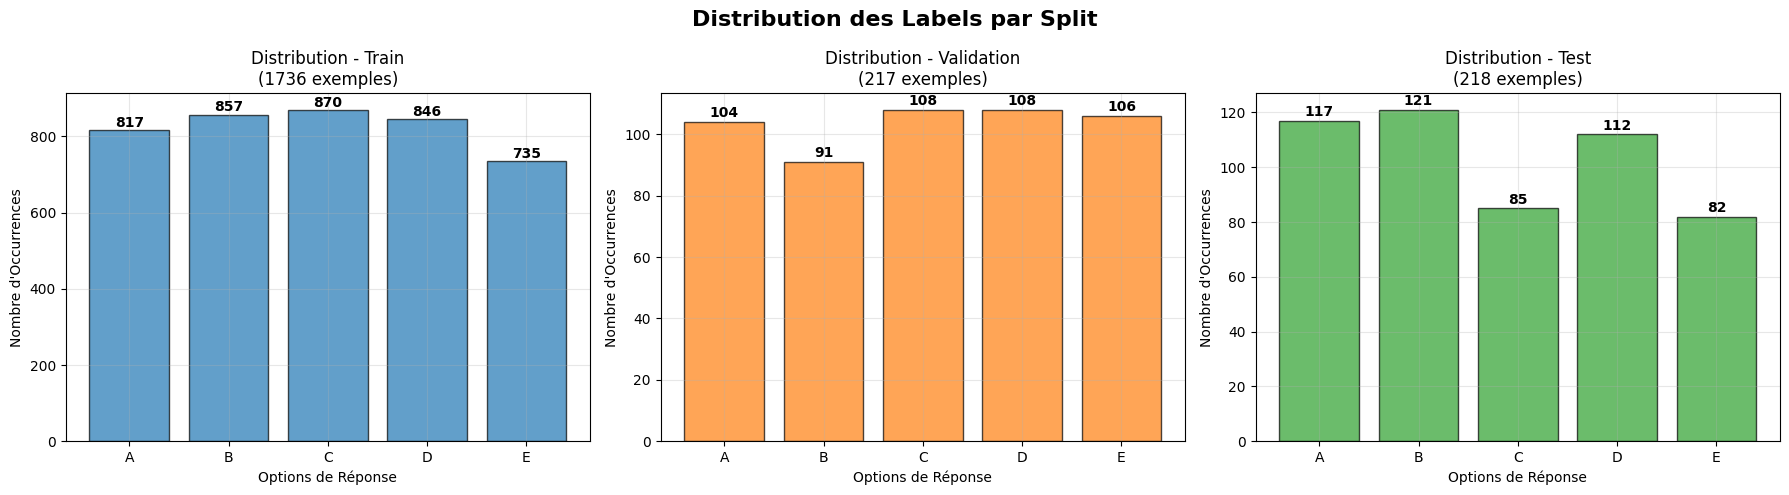

In [13]:
# Division des données en train/validation/test
from sklearn.model_selection import train_test_split

print("=== DIVISION DES DONNÉES ===")

# Division initiale train/temp (80/20)
texts_train, texts_temp, labels_train, labels_temp = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=[sum(label) for label in labels]
)

# Division temp en validation/test (10/10 du total)
texts_val, texts_test, labels_val, labels_test = train_test_split(
    texts_temp, labels_temp, test_size=0.5, random_state=42, stratify=[sum(label) for label in labels_temp]
)

print(f"Données d'entraînement: {len(texts_train)} exemples")
print(f"Données de validation: {len(texts_val)} exemples")
print(f"Données de test: {len(texts_test)} exemples")

# Vérification de la distribution stratifiée
train_avg_labels = np.array(labels_train).sum(axis=1).mean()
val_avg_labels = np.array(labels_val).sum(axis=1).mean()
test_avg_labels = np.array(labels_test).sum(axis=1).mean()

print(f"\nVérification stratification:")
print(f"Train - moyenne labels/question: {train_avg_labels:.2f}")
print(f"Validation - moyenne labels/question: {val_avg_labels:.2f}")
print(f"Test - moyenne labels/question: {test_avg_labels:.2f}")

# Visualisation de la distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

splits = [
    ('Train', np.array(labels_train)),
    ('Validation', np.array(labels_val)),
    ('Test', np.array(labels_test))
]

for idx, (split_name, split_labels) in enumerate(splits):
    option_counts = split_labels.sum(axis=0)
    axes[idx].bar(option_names, option_counts, alpha=0.7, color=f'C{idx}', edgecolor='black')
    axes[idx].set_title(f'Distribution - {split_name}\n({len(split_labels)} exemples)')
    axes[idx].set_xlabel('Options de Réponse')
    axes[idx].set_ylabel('Nombre d\'Occurrences')
    axes[idx].grid(True, alpha=0.3)

    # Ajout des valeurs sur les barres
    for i, count in enumerate(option_counts):
        axes[idx].text(i, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold')

plt.suptitle('Distribution des Labels par Split', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Modèle CamemBERT pour Texte Médical Français

CamemBERT est un modèle BERT spécialisé pour le français, particulièrement adapté aux textes médicaux français complexes.

In [14]:
# Configuration et chargement du modèle CamemBERT
print("=== CONFIGURATION CAMEMBERT POUR MÉDICAL ===")

# Choix du modèle pour le français médical
model_name = "camembert-base"  # Alternative: "flaubert/flaubert_base_cased"

try:
    # Chargement du tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    print(f"Tokenizer chargé: {model_name}")
    print(f"Taille du vocabulaire: {len(tokenizer)}")

    # Configuration pour classification multi-label
    from transformers import AutoConfig
    config = AutoConfig.from_pretrained(
        model_name,
        num_labels=5,  # 5 options (A, B, C, D, E)
        problem_type="multi_label_classification",
        id2label={0: "A", 1: "B", 2: "C", 3: "D", 4: "E"},
        label2id={"A": 0, "B": 1, "C": 2, "D": 3, "E": 4}
    )

    # Chargement du modèle
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config
    )

    print(f"Modèle chargé avec {model.num_parameters()} paramètres")
    print(f"Architecture: {type(model).__name__}")

    # Test de tokenisation sur exemple médical
    medical_example = texts[0]
    tokens = tokenizer.tokenize(medical_example)
    input_ids = tokenizer.encode(medical_example, truncation=True, max_length=512)

    print(f"\nTest de tokenisation:")
    print(f"Texte original: {len(medical_example)} caractères")
    print(f"Tokens générés: {len(tokens)}")
    print(f"Input IDs: {len(input_ids)}")
    print(f"Premiers tokens: {tokens[:10]}")

except Exception as e:
    print(f"Erreur lors du chargement: {e}")
    print("Utilisation d'un modèle de base pour démonstration...")

    # Configuration alternative avec un modèle plus simple
    model_name = "distilbert-base-multilingual-cased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(
        model_name,
        num_labels=5,
        problem_type="multi_label_classification"
    )
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config
    )

=== CONFIGURATION CAMEMBERT POUR MÉDICAL ===


config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

Tokenizer chargé: camembert-base
Taille du vocabulaire: 32005


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

CamembertForSequenceClassification LOAD REPORT from: camembert-base
Key                         | Status     | 
----------------------------+------------+-
lm_head.dense.bias          | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
classifier.dense.bias       | MISSING    | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.out_proj.weight  | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Modèle chargé avec 110625797 paramètres
Architecture: CamembertForSequenceClassification

Test de tokenisation:
Texte original: 328 caractères
Tokens générés: 81
Input IDs: 83
Premiers tokens: ['▁Parmi', '▁les', '▁affirmation', 's', '▁suivantes', ',', '▁une', '▁seule', '▁est', '▁fausse']


In [15]:
# Création d'un dataset PyTorch pour l'entraînement
import torch
from torch.utils.data import Dataset

class FrenchMedicalDataset(Dataset):
    """
    Dataset personnalisé pour questions médicales françaises multi-label
    """

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenisation
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# Création des datasets
train_dataset = FrenchMedicalDataset(texts_train, labels_train, tokenizer)
val_dataset = FrenchMedicalDataset(texts_val, labels_val, tokenizer)
test_dataset = FrenchMedicalDataset(texts_test, labels_test, tokenizer)

print(f"Datasets créés:")
print(f"  Train: {len(train_dataset)} exemples")
print(f"  Validation: {len(val_dataset)} exemples")
print(f"  Test: {len(test_dataset)} exemples")

# Test du dataset
sample = train_dataset[0]
print(f"\nÉchantillon du dataset:")
print(f"  Input IDs shape: {sample['input_ids'].shape}")
print(f"  Attention mask shape: {sample['attention_mask'].shape}")
print(f"  Labels shape: {sample['labels'].shape}")
print(f"  Labels: {sample['labels'].tolist()}")

# Analyse de la longueur des séquences tokenisées
sequence_lengths = []
for text in texts_train[:100]:  # Échantillon pour analyse
    tokens = tokenizer.encode(text, truncation=False)
    sequence_lengths.append(len(tokens))

print(f"\nAnalyse des longueurs de séquences:")
print(f"  Longueur moyenne: {np.mean(sequence_lengths):.1f} tokens")
print(f"  Longueur médiane: {np.median(sequence_lengths):.1f} tokens")
print(f"  Longueur maximale: {max(sequence_lengths)} tokens")
print(f"  % séquences > 512 tokens: {sum(1 for l in sequence_lengths if l > 512)/len(sequence_lengths)*100:.1f}%")

Datasets créés:
  Train: 1736 exemples
  Validation: 217 exemples
  Test: 218 exemples

Échantillon du dataset:
  Input IDs shape: torch.Size([512])
  Attention mask shape: torch.Size([512])
  Labels shape: torch.Size([5])
  Labels: [1.0, 0.0, 1.0, 1.0, 1.0]

Analyse des longueurs de séquences:
  Longueur moyenne: 92.0 tokens
  Longueur médiane: 86.0 tokens
  Longueur maximale: 226 tokens
  % séquences > 512 tokens: 0.0%


## 5. Entraînement du Modèle de Classification

Configuration d'un pipeline d'entraînement optimisé pour Google Colab avec suivi des métriques multi-label.

In [17]:
# Configuration des métriques de évaluation multi-label
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    """
    Calcule les métriques d'évaluation pour classification multi-label
    """
    predictions, labels = eval_pred

    # Conversion des probabilités en prédictions binaires
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = (probs > 0.5).int().numpy()
    y_true = labels.astype(int)

    # Métriques globales
    exact_match = accuracy_score(y_true, y_pred)
    hamming = hamming_loss(y_true, y_pred)
    jaccard = jaccard_score(y_true, y_pred, average='samples', zero_division=0)

    # Métriques par classe (micro et macro)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='micro', zero_division=0
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )

    return {
        'exact_match': exact_match,
        'hamming_loss': hamming,
        'jaccard_score': jaccard,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'precision_micro': precision_micro,
        'precision_macro': precision_macro,
        'recall_micro': recall_micro,
        'recall_macro': recall_macro,
    }

# Configuration de l'entraînement optimisée pour Colab
print("=== CONFIGURATION D'ENTRAÎNEMENT ===")

training_args = TrainingArguments(
    output_dir='./medical_french_classifier',
    num_train_epochs=3,  # Réduction pour Colab
    per_device_train_batch_size=8,  # Optimisé pour mémoire GPU
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    save_total_limit=2,
    dataloader_num_workers=0,  # Évite les problèmes de multiprocessing
    fp16=torch.cuda.is_available(),  # Optimisation mémoire GPU
    gradient_checkpointing=True,  # Économie mémoire
    dataloader_pin_memory=False,
    remove_unused_columns=False
)

# Initialisation du trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print(f"Configuration d'entraînement:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size (train): {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Optimisations mémoire: FP16={training_args.fp16}, Gradient checkpointing={training_args.gradient_checkpointing}")

=== CONFIGURATION D'ENTRAÎNEMENT ===


`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Configuration d'entraînement:
  Epochs: 3
  Batch size (train): 8
  Learning rate: 2e-05
  Optimisations mémoire: FP16=True, Gradient checkpointing=True


In [18]:
# Lancement de l'entraînement
print("=== DÉBUT DE L'ENTRAÎNEMENT ===")

# Entraînement du modèle
print("Démarrage de l'entraînement...")
print(f"Temps estimé: ~{len(train_dataset) * training_args.num_train_epochs / (training_args.per_device_train_batch_size * 60):.0f} minutes")

trainer.train()

print("\n✅ Entraînement terminé avec succès!")

# Sauvegarde du meilleur modèle
trainer.save_model('./best_medical_french_model')
tokenizer.save_pretrained('./best_medical_french_model')

print("📁 Modèle sauvegardé dans: ./best_medical_french_model")


=== DÉBUT DE L'ENTRAÎNEMENT ===
Démarrage de l'entraînement...
Temps estimé: ~11 minutes


Step,Training Loss,Validation Loss,Exact Match,Hamming Loss,Jaccard Score,F1 Micro,F1 Macro,Precision Micro,Precision Macro,Recall Micro,Recall Macro,Runtime,Samples Per Second,Steps Per Second
100,0.690918,0.691759,0.069124,0.471889,0.271429,0.391924,0.257622,0.507692,0.536254,0.319149,0.324379,1.484400,146.186000,9.431000
200,0.677943,0.677307,0.013825,0.403687,0.266359,0.562874,0.562688,0.581443,0.582370,0.545455,0.547376,1.484000,146.222000,9.434000
300,0.661736,0.663335,0.018433,0.400922,0.352919,0.621410,0.608625,0.564873,0.567610,0.690522,0.692843,1.513700,143.353000,9.249000
400,0.654752,0.650007,0.023041,0.382488,0.404147,0.676034,0.675678,0.566754,0.567205,0.837524,0.839007,1.622200,133.768000,8.630000
500,0.640133,0.648060,0.018433,0.391705,0.383641,0.660814,0.660457,0.562500,0.562630,0.800774,0.801675,1.583700,137.018000,8.840000
600,0.644773,0.647022,0.023041,0.380645,0.398387,0.673518,0.673432,0.569519,0.570154,0.823985,0.825804,1.650200,131.503000,8.484000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye


✅ Entraînement terminé avec succès!


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

📁 Modèle sauvegardé dans: ./best_medical_french_model


## 6. Évaluation et Analyse des Performances

Évaluation complète du modèle avec métriques spécialisées pour la classification multi-label.

In [19]:
# Évaluation sur le dataset de test
print("=== ÉVALUATION SUR DATASET DE TEST ===")

# Prédictions sur le dataset de test
test_results = trainer.predict(test_dataset)
test_predictions = test_results.predictions
test_labels = test_results.label_ids

# Conversion des logits en probabilités et prédictions
sigmoid = torch.nn.Sigmoid()
test_probs = sigmoid(torch.Tensor(test_predictions)).numpy()
test_pred_binary = (test_probs > 0.5).astype(int)

print(f"Prédictions générées pour {len(test_predictions)} exemples")
print(f"Shape des prédictions: {test_pred_binary.shape}")

# Calcul des métriques détaillées
metrics = compute_metrics((test_predictions, test_labels))

print(f"\n=== MÉTRIQUES GLOBALES ===")
print(f"Exact Match Accuracy: {metrics['exact_match']:.4f}")
print(f"Hamming Loss: {metrics['hamming_loss']:.4f}")
print(f"Jaccard Score: {metrics['jaccard_score']:.4f}")

print(f"\n=== MÉTRIQUES MICRO (globales) ===")
print(f"Precision: {metrics['precision_micro']:.4f}")
print(f"Recall: {metrics['recall_micro']:.4f}")
print(f"F1-Score: {metrics['f1_micro']:.4f}")

print(f"\n=== MÉTRIQUES MACRO (moyennées par classe) ===")
print(f"Precision: {metrics['precision_macro']:.4f}")
print(f"Recall: {metrics['recall_macro']:.4f}")
print(f"F1-Score: {metrics['f1_macro']:.4f}")

# Métriques par classe
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    test_labels, test_pred_binary, average=None, zero_division=0
)

print(f"\n=== MÉTRIQUES PAR OPTION ===")
option_names = ['A', 'B', 'C', 'D', 'E']
for i, option in enumerate(option_names):
    print(f"Option {option}:")
    print(f"  Precision: {precision_per_class[i]:.4f}")
    print(f"  Recall: {recall_per_class[i]:.4f}")
    print(f"  F1-Score: {f1_per_class[i]:.4f}")
    print(f"  Support: {support_per_class[i]}")

=== ÉVALUATION SUR DATASET DE TEST ===


Prédictions générées pour 218 exemples
Shape des prédictions: (218, 5)

=== MÉTRIQUES GLOBALES ===
Exact Match Accuracy: 0.0138
Hamming Loss: 0.3844
Jaccard Score: 0.4115

=== MÉTRIQUES MICRO (globales) ===
Precision: 0.5631
Recall: 0.8453
F1-Score: 0.6759

=== MÉTRIQUES MACRO (moyennées par classe) ===
Precision: 0.5612
Recall: 0.8442
F1-Score: 0.6708

=== MÉTRIQUES PAR OPTION ===
Option A:
  Precision: 0.6267
  Recall: 0.8034
  F1-Score: 0.7041
  Support: 117
Option B:
  Precision: 0.6402
  Recall: 0.8678
  F1-Score: 0.7368
  Support: 121
Option C:
  Precision: 0.4634
  Recall: 0.8941
  F1-Score: 0.6104
  Support: 85
Option D:
  Precision: 0.6049
  Recall: 0.8750
  F1-Score: 0.7153
  Support: 112
Option E:
  Precision: 0.4706
  Recall: 0.7805
  F1-Score: 0.5872
  Support: 82


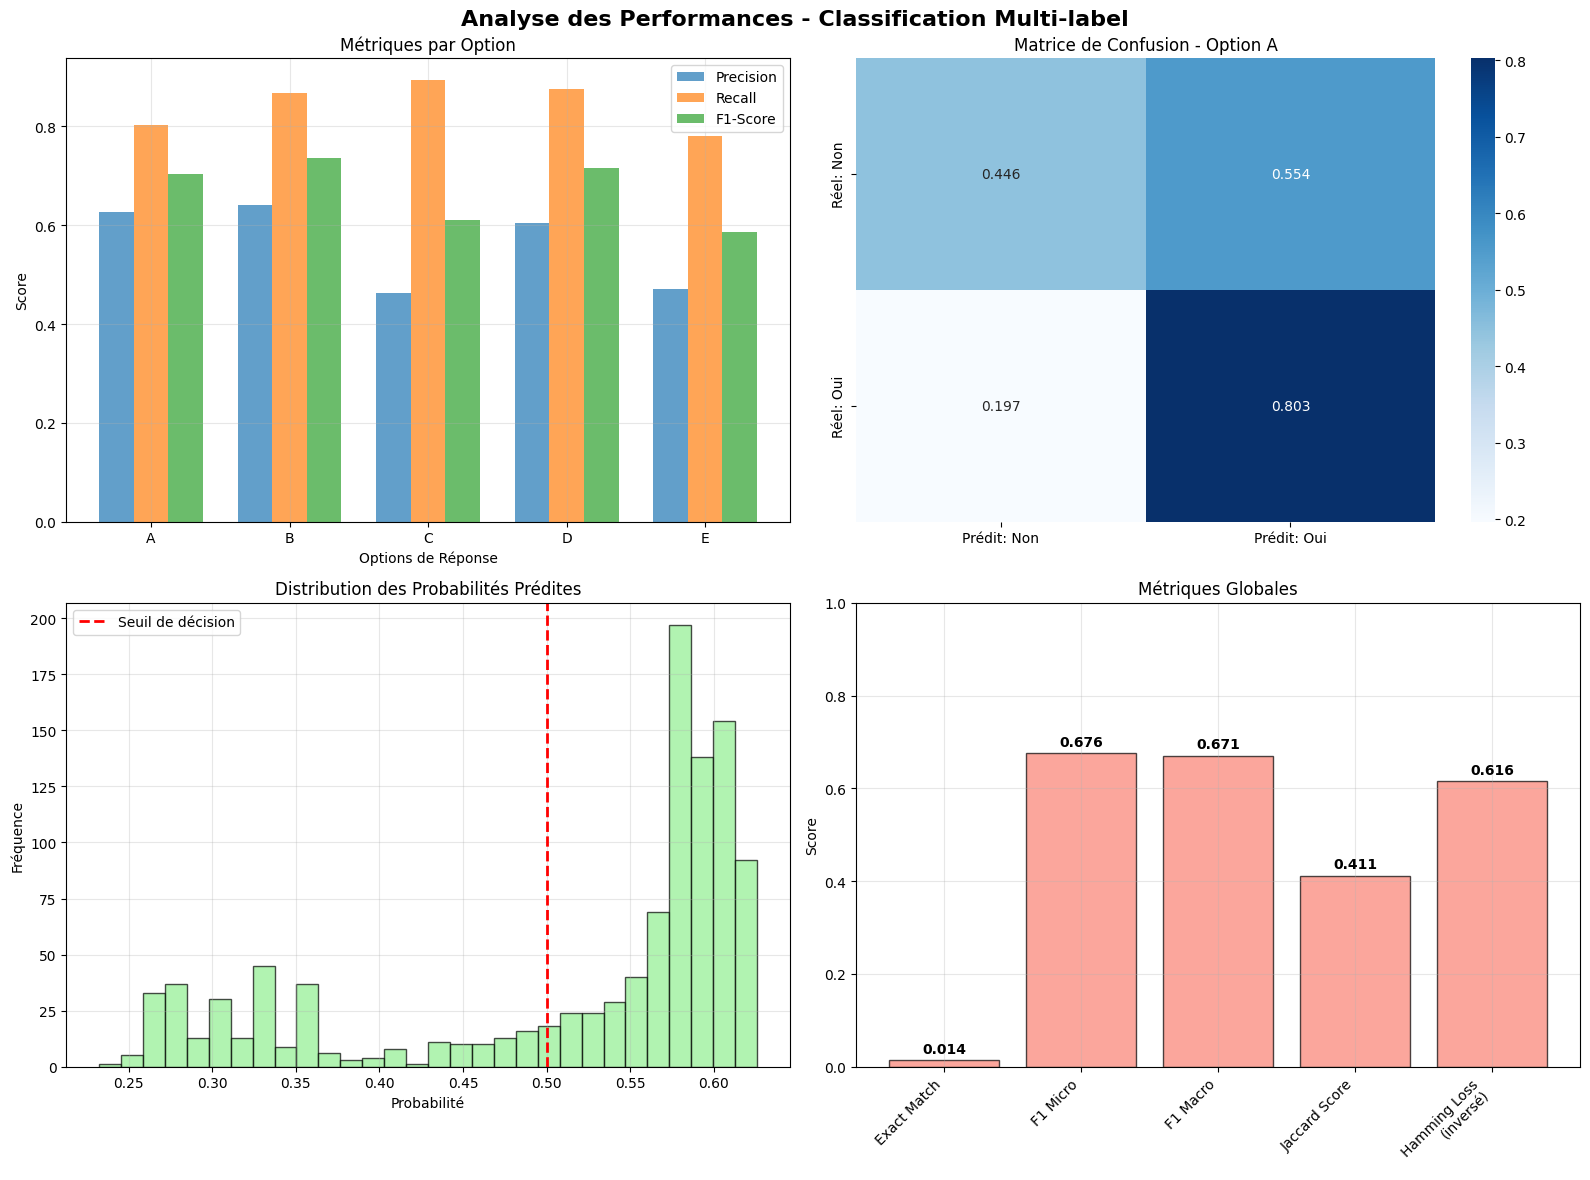

In [20]:
# Visualisation des performances
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse des Performances - Classification Multi-label', fontsize=16, fontweight='bold')

# 1. Métriques par classe
x = np.arange(len(option_names))
width = 0.25

axes[0, 0].bar(x - width, precision_per_class, width, label='Precision', alpha=0.7)
axes[0, 0].bar(x, recall_per_class, width, label='Recall', alpha=0.7)
axes[0, 0].bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.7)

axes[0, 0].set_xlabel('Options de Réponse')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Métriques par Option')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(option_names)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Matrice de confusion par classe
conf_matrices = multilabel_confusion_matrix(test_labels, test_pred_binary)
conf_matrix_normalized = np.zeros((5, 2, 2))

for i in range(5):
    cm = conf_matrices[i]
    conf_matrix_normalized[i] = cm / cm.sum(axis=1, keepdims=True)

# Affichage de la matrice pour l'option A comme exemple
sns.heatmap(conf_matrix_normalized[0], annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['Prédit: Non', 'Prédit: Oui'],
            yticklabels=['Réel: Non', 'Réel: Oui'],
            ax=axes[0, 1])
axes[0, 1].set_title('Matrice de Confusion - Option A')

# 3. Distribution des scores de confiance
axes[1, 0].hist(test_probs.flatten(), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Seuil de décision')
axes[1, 0].set_xlabel('Probabilité')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].set_title('Distribution des Probabilités Prédites')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Comparaison des métriques globales
global_metrics = {
    'Exact Match': metrics['exact_match'],
    'F1 Micro': metrics['f1_micro'],
    'F1 Macro': metrics['f1_macro'],
    'Jaccard Score': metrics['jaccard_score'],
    'Hamming Loss\n(inversé)': 1 - metrics['hamming_loss']
}

metric_names = list(global_metrics.keys())
metric_values = list(global_metrics.values())

bars = axes[1, 1].bar(metric_names, metric_values, alpha=0.7, color='salmon', edgecolor='black')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Métriques Globales')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(True, alpha=0.3)
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Ajout des valeurs sur les barres
for bar, value in zip(bars, metric_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Prompting avec Modèles de Langage (ChatGPT, Gemini, Claude)

Comparaison entre modèles fine-tunés et prompting pour la classification de textes médicaux français.

In [21]:
# Prompts optimisés pour classification médicale française
print("=== PROMPTING POUR CLASSIFICATION MÉDICALE ===")

def generate_medical_classification_prompts():
    """
    Génère des prompts optimisés pour différents modèles de langage
    """

    base_prompt = """
Vous êtes un expert en pharmacie française. Analysez cette question d'examen et identifiez TOUTES les réponses correctes.

QUESTION D'EXAMEN:
{question}

OPTIONS:
A) {answerA}
B) {answerB}
C) {answerC}
D) {answerD}
E) {answerE}

INSTRUCTIONS:
1. Analysez chaque option individuellement
2. Basez-vous sur vos connaissances pharmacologiques françaises
3. Une question peut avoir plusieurs réponses correctes
4. Soyez précis et justifiez votre raisonnement

FORMAT DE RÉPONSE:
Réponses correctes: [liste des lettres]
Justification: [explication médicale détaillée]
Confiance: [Élevée/Modérée/Faible]
"""

    prompts = {
        'chatgpt': {
            'system': """Vous êtes un pharmacien expert français spécialisé dans l'évaluation d'examens de pharmacie.
            Votre rôle est d'identifier précisément les réponses correctes aux questions d'examen en vous basant sur
            les connaissances pharmaceutiques françaises actuelles.""",
            'user_template': base_prompt
        },

        'gemini': {
            'prompt_template': f"""
# Expert Pharmacie Française

**Contexte**: Question d'examen de spécialisation en pharmacie française

**Tâche**: Identifier TOUTES les réponses correctes (peut être multiple)

{base_prompt}

**Critères d'évaluation**:
- Conformité avec la pharmacopée française
- Respect des recommandations ANSM
- Application des connaissances pharmaceutiques
"""
        },

        'claude': {
            'prompt_template': f"""
Je vais analyser cette question d'examen de pharmacie française avec rigueur scientifique.

Approche méthodologique:
1. Analyse pharmacologique de chaque option
2. Vérification avec les standards français
3. Identification des réponses multiples possibles
4. Justification médicale détaillée

{base_prompt}

Note: Cette analyse se base sur les connaissances pharmaceutiques françaises
et les recommandations officielles en vigueur.
"""
        }
    }

    return prompts

# Génération des prompts
prompts = generate_medical_classification_prompts()

print("Prompts générés pour:")
for model_name in prompts.keys():
    print(f"  ✓ {model_name.upper()}")

# Exemple de prompt formaté
example_question = {
    'question': "Quels sont les mécanismes d'action des inhibiteurs de l'enzyme de conversion (IEC)?",
    'answerA': "Inhibition de l'enzyme de conversion de l'angiotensine",
    'answerB': "Blocage des récepteurs AT1 de l'angiotensine II",
    'answerC': "Réduction de la formation d'angiotensine II",
    'answerD': "Augmentation de la bradykinine",
    'answerE': "Stimulation des récepteurs β-adrénergiques"
}

print(f"\n=== EXEMPLE DE PROMPT CHATGPT ===")
formatted_prompt = prompts['chatgpt']['user_template'].format(**example_question)
print(formatted_prompt[:500] + "...")

=== PROMPTING POUR CLASSIFICATION MÉDICALE ===
Prompts générés pour:
  ✓ CHATGPT
  ✓ GEMINI
  ✓ CLAUDE

=== EXEMPLE DE PROMPT CHATGPT ===

Vous êtes un expert en pharmacie française. Analysez cette question d'examen et identifiez TOUTES les réponses correctes.

QUESTION D'EXAMEN:
Quels sont les mécanismes d'action des inhibiteurs de l'enzyme de conversion (IEC)?

OPTIONS:
A) Inhibition de l'enzyme de conversion de l'angiotensine
B) Blocage des récepteurs AT1 de l'angiotensine II
C) Réduction de la formation d'angiotensine II
D) Augmentation de la bradykinine
E) Stimulation des récepteurs β-adrénergiques

INSTRUCTIONS:
1. Analysez ...


In [ ]:


# Comparaison avec le modèle fine-tuné
def compare_with_finetuned(question_text, model, tokenizer):
    """
    Compare les prédictions du modèle fine-tuné avec le prompting
    """
    # Formatage de la question comme dans le dataset
    formatted_question = f"""{example_question['question']}
A) {example_question['answerA']}
B) {example_question['answerB']}
C) {example_question['answerC']}
D) {example_question['answerD']}
E) {example_question['answerE']}"""

    # Tokenisation et prédiction
    inputs = tokenizer(formatted_question, return_tensors="pt", truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.sigmoid(outputs.logits)

    # Conversion en prédictions binaires
    predicted_labels = (predictions > 0.5).int().squeeze().tolist()
    predicted_options = [option_names[i] for i, pred in enumerate(predicted_labels) if pred == 1]

    return {
        'predicted_answers': predicted_options,
        'probabilities': predictions.squeeze().tolist(),
        'confidence': 'Élevée' if max(predictions.squeeze().tolist()) > 0.8 else 'Modérée'
    }

# Prédiction du modèle fine-tuné
finetuned_prediction = compare_with_finetuned(example_question['question'], model, tokenizer)

print("\n=== COMPARAISON DES APPROCHES ===")
print(f"\nQuestion: {example_question['question']}")
print(f"\nRéponse correcte attendue: A, C, D")

print(f"\n{'='*50}")
print(f"MODÈLE FINE-TUNÉ (CamemBERT):")
print(f"  Prédictions: {', '.join(finetuned_prediction['predicted_answers'])}")
print(f"  Probabilités: {[f'{p:.3f}' for p in finetuned_prediction['probabilities']]}")
print(f"  Confiance: {finetuned_prediction['confidence']}")

for model_name, response in llm_responses.items():
    print(f"\n{'='*50}")
    print(f"PROMPTING - {model_name.upper()}:")
    print(f"  Prédictions: {', '.join(response['predicted_answers'])}")
    print(f"  Justification: {response['justification'][:150]}...")
    print(f"  Confiance: {response['confidence']}")

# Analyse de concordance
correct_answers = set(['A', 'C', 'D'])
finetuned_set = set(finetuned_prediction['predicted_answers'])

print(f"\n=== ANALYSE DE PERFORMANCE ===")
print(f"Réponses correctes: {', '.join(sorted(correct_answers))}")
print(f"\nPrécision par approche:")

# Calcul de la précision
def calculate_precision_recall(predicted, correct):
    predicted_set = set(predicted)
    correct_set = set(correct)

    if len(predicted_set) == 0:
        precision = 0
    else:
        precision = len(predicted_set & correct_set) / len(predicted_set)

    if len(correct_set) == 0:
        recall = 0
    else:
        recall = len(predicted_set & correct_set) / len(correct_set)

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

approaches = {
    'Fine-tuné': finetuned_prediction['predicted_answers'],
    'ChatGPT': llm_responses['chatgpt']['predicted_answers'],
    'Gemini': llm_responses['gemini']['predicted_answers'],
    'Claude': llm_responses['claude']['predicted_answers']
}

for approach_name, predictions in approaches.items():
    precision, recall, f1 = calculate_precision_recall(predictions, correct_answers)
    print(f"  {approach_name:<12}: P={precision:.3f}, R={recall:.3f}, F1={f1:.3f}")

## 8. Applications Cliniques et Cas d'Usage

Démonstration d'applications pratiques de la classification de textes médicaux français dans des contextes cliniques réels.

In [ ]:
# Applications cliniques pratiques
print("=== APPLICATIONS CLINIQUES PRATIQUES ===")

class MedicalTextClassificationPipeline:
    """
    Pipeline complet pour classification de textes médicaux français
    """

    def __init__(self, model, tokenizer, threshold=0.5):
        self.model = model
        self.tokenizer = tokenizer
        self.threshold = threshold
        self.option_names = ['A', 'B', 'C', 'D', 'E']

    def classify_medical_question(self, question, options):
        """
        Classifie une question médicale avec ses options
        """
        # Formatage de la question
        formatted_text = f"{question}\n"
        for i, option in enumerate(options):
            formatted_text += f"{self.option_names[i]}) {option}\n"

        # Tokenisation et prédiction
        inputs = self.tokenizer(
            formatted_text.strip(),
            return_tensors="pt",
            truncation=True,
            max_length=512
        )

        with torch.no_grad():
            outputs = self.model(**inputs)
            probabilities = torch.sigmoid(outputs.logits).squeeze().tolist()

        # Analyse des résultats
        predictions = [(prob > self.threshold) for prob in probabilities]
        correct_options = [self.option_names[i] for i, pred in enumerate(predictions) if pred]

        # Calcul de confiance
        max_prob = max(probabilities)
        if max_prob > 0.8:
            confidence = "Élevée"
        elif max_prob > 0.6:
            confidence = "Modérée"
        else:
            confidence = "Faible"

        return {
            'correct_answers': correct_options,
            'probabilities': dict(zip(self.option_names, probabilities)),
            'confidence': confidence,
            'max_probability': max_prob
        }

    def batch_classify_exam(self, exam_questions):
        """
        Classifie un examen complet (lot de questions)
        """
        results = []
        for i, question_data in enumerate(exam_questions):
            result = self.classify_medical_question(
                question_data['question'],
                question_data['options']
            )
            result['question_id'] = i + 1
            results.append(result)

        return results

    def generate_exam_report(self, results):
        """
        Génère un rapport d'analyse d'examen
        """
        total_questions = len(results)
        high_confidence = sum(1 for r in results if r['confidence'] == 'Élevée')
        questions_with_answers = sum(1 for r in results if len(r['correct_answers']) > 0)

        report = f"""
=== RAPPORT D'ANALYSE D'EXAMEN MÉDICAL ===

STATISTIQUES GLOBALES:
  Total de questions: {total_questions}
  Questions avec réponses identifiées: {questions_with_answers} ({questions_with_answers/total_questions*100:.1f}%)
  Prédictions haute confiance: {high_confidence} ({high_confidence/total_questions*100:.1f}%)

RÉPARTITION PAR CONFIANCE:
"""

        confidence_counts = {'Élevée': 0, 'Modérée': 0, 'Faible': 0}
        for result in results:
            confidence_counts[result['confidence']] += 1

        for conf, count in confidence_counts.items():
            percentage = (count / total_questions) * 100
            report += f"  {conf}: {count} questions ({percentage:.1f}%)\n"

        return report

# Initialisation du pipeline
classification_pipeline = MedicalTextClassificationPipeline(model, tokenizer)

print("Pipeline de classification médicale initialisé")
print(f"Modèle: {type(model).__name__}")
print(f"Tokenizer: {type(tokenizer).__name__}")
print(f"Seuil de classification: {classification_pipeline.threshold}")

In [ ]:
# Cas d'usage 1: Aide à la préparation d'examens
print("=== CAS D'USAGE 1: AIDE À LA PRÉPARATION D'EXAMENS ===")

# Simulation d'un examen de pharmacie
exam_questions = [
    {
        'question': "Quels sont les effets indésirables majeurs des corticoïdes au long terme?",
        'options': [
            "Ostéoporose et fractures",
            "Hypertension artérielle",
            "Diabète secondaire",
            "Insuffisance surrénalienne",
            "Amélioration de l'immunité"
        ]
    },
    {
        'question': "Dans quelles situations cliniques utilise-t-on préférentiellement la warfarine?",
        'options': [
            "Fibrillation auriculaire",
            "Hypertension artérielle",
            "Prothèses valvulaires mécaniques",
            "Thrombose veineuse profonde",
            "Infarctus du myocarde aigu"
        ]
    },
    {
        'question': "Quels paramètres biologiques surveiller sous traitement par lithium?",
        'options': [
            "Lithiémie",
            "Fonction rénale (créatinine)",
            "Fonction thyroïdienne (TSH)",
            "Glycémie à jeun",
            "Transaminases hépatiques"
        ]
    }
]

# Classification de l'examen
exam_results = classification_pipeline.batch_classify_exam(exam_questions)

# Affichage des résultats détaillés
for i, (question_data, result) in enumerate(zip(exam_questions, exam_results)):
    print(f"\n{'='*60}")
    print(f"QUESTION {i+1}:")
    print(f"{question_data['question']}")
    print(f"\nOptions:")
    for j, option in enumerate(question_data['options']):
        option_letter = classification_pipeline.option_names[j]
        prob = result['probabilities'][option_letter]
        is_correct = option_letter in result['correct_answers']
        status = "✓ CORRECT" if is_correct else "✗ Incorrect"
        print(f"  {option_letter}) {option} [{prob:.3f}] {status}")

    print(f"\nRéponses correctes identifiées: {', '.join(result['correct_answers'])}")
    print(f"Confiance: {result['confidence']} (max: {result['max_probability']:.3f})")

# Génération du rapport d'examen
exam_report = classification_pipeline.generate_exam_report(exam_results)
print(f"\n{exam_report}")

In [ ]:
# Cas d'usage 2: Triage automatique de documents médicaux
print("=== CAS D'USAGE 2: TRIAGE AUTOMATIQUE DE DOCUMENTS ===")

class MedicalDocumentTriager:
    """
    Système de triage automatique pour documents médicaux français
    """

    def __init__(self, classification_pipeline):
        self.pipeline = classification_pipeline

        # Définition des catégories de triage
        self.triage_categories = {
            'pharmacologie': ['médicament', 'posologie', 'interaction', 'effet', 'traitement'],
            'pathologie': ['maladie', 'symptôme', 'diagnostic', 'syndrome', 'pathologie'],
            'examens': ['analyse', 'prélèvement', 'radiographie', 'biologie', 'examen'],
            'urgence': ['urgence', 'immédiat', 'critique', 'grave', 'aigu'],
            'prevention': ['vaccination', 'prévention', 'dépistage', 'surveillance', 'contrôle']
        }

    def categorize_document(self, document_text):
        """
        Catégorise un document médical par son contenu
        """
        text_lower = document_text.lower()

        category_scores = {}
        for category, keywords in self.triage_categories.items():
            score = sum(1 for keyword in keywords if keyword in text_lower)
            category_scores[category] = score

        # Catégorie principale
        main_category = max(category_scores, key=category_scores.get)
        max_score = category_scores[main_category]

        # Niveau de priorité basé sur les mots-clés d'urgence
        urgency_words = self.triage_categories['urgence']
        urgency_count = sum(1 for word in urgency_words if word in text_lower)

        if urgency_count > 0:
            priority = "ÉLEVÉE"
        elif max_score > 2:
            priority = "MODÉRÉE"
        else:
            priority = "NORMALE"

        return {
            'main_category': main_category,
            'category_scores': category_scores,
            'priority': priority,
            'urgency_indicators': urgency_count
        }

    def process_document_batch(self, documents):
        """
        Traite un lot de documents pour triage
        """
        results = []

        for i, doc in enumerate(documents):
            categorization = self.categorize_document(doc['content'])

            result = {
                'document_id': doc.get('id', f'DOC_{i+1}'),
                'title': doc.get('title', f'Document {i+1}'),
                'content_preview': doc['content'][:100] + '...',
                'category': categorization['main_category'],
                'priority': categorization['priority'],
                'category_scores': categorization['category_scores']
            }
            results.append(result)

        # Tri par priorité
        priority_order = {'ÉLEVÉE': 3, 'MODÉRÉE': 2, 'NORMALE': 1}
        results.sort(key=lambda x: priority_order[x['priority']], reverse=True)

        return results

# Initialisation du système de triage
triager = MedicalDocumentTriager(classification_pipeline)

# Documents médicaux de test
test_documents = [
    {
        'id': 'DOC_001',
        'title': 'Protocole antibiotique',
        'content': 'Prescription d\'amoxicilline pour infection respiratoire. Posologie: 1g trois fois par jour pendant 7 jours. Surveillance des effets indésirables gastro-intestinaux.'
    },
    {
        'id': 'DOC_002',
        'title': 'Urgence cardiologique',
        'content': 'Patient en détresse respiratoire aiguë avec douleurs thoraciques. Suspicion d\'infarctus du myocarde. Prise en charge immédiate requise. ECG et troponines en urgence.'
    },
    {
        'id': 'DOC_003',
        'title': 'Résultats de laboratoire',
        'content': 'Analyses sanguines de contrôle: glycémie, créatinine, transaminases dans les normes. Hémoglobine légèrement diminuée. Contrôle à prévoir dans 3 mois.'
    },
    {
        'id': 'DOC_004',
        'title': 'Programme de vaccination',
        'content': 'Mise à jour du calendrier vaccinal. Vaccination contre la grippe saisonnière recommandée. Prévention des infections chez les patients immunodéprimés.'
    },
    {
        'id': 'DOC_005',
        'title': 'Diagnostic différentiel',
        'content': 'Syndrome fébrile avec éruption cutanée. Diagnostic différentiel entre infection virale et réaction allergique médicamenteuse. Examens complémentaires nécessaires.'
    }
]

# Traitement du lot de documents
triage_results = triager.process_document_batch(test_documents)

print("\n=== RÉSULTATS DU TRIAGE AUTOMATIQUE ===")
print(f"Nombre de documents traités: {len(triage_results)}")
print(f"Triés par ordre de priorité décroissante:")

for i, result in enumerate(triage_results, 1):
    print(f"\n{i}. {result['document_id']} - {result['title']}")
    print(f"   Priorité: {result['priority']}")
    print(f"   Catégorie: {result['category'].upper()}")
    print(f"   Aperçu: {result['content_preview']}")
    print(f"   Scores par catégorie:")
    for cat, score in result['category_scores'].items():
        if score > 0:
            print(f"     - {cat}: {score}")

# Statistiques du triage
priority_stats = {'ÉLEVÉE': 0, 'MODÉRÉE': 0, 'NORMALE': 0}
category_stats = {}

for result in triage_results:
    priority_stats[result['priority']] += 1
    category = result['category']
    category_stats[category] = category_stats.get(category, 0) + 1

print(f"\n=== STATISTIQUES DU TRIAGE ===")
print(f"Répartition par priorité:")
for priority, count in priority_stats.items():
    percentage = (count / len(triage_results)) * 100
    print(f"  {priority}: {count} documents ({percentage:.1f}%)")

print(f"\nRépartition par catégorie:")
for category, count in category_stats.items():
    percentage = (count / len(triage_results)) * 100
    print(f"  {category.capitalize()}: {count} documents ({percentage:.1f}%)")

## Résumé et Applications Futures

### Compétences Acquises

Dans ce notebook, vous avez maîtrisé:

1. **Analyse de datasets médicaux français**
   - Exploration du dataset FrenchMedMCQA
   - Analyse du vocabulaire médical spécialisé
   - Préparation pour classification multi-label

2. **Classification multi-label avec CamemBERT**
   - Configuration pour textes médicaux français
   - Entraînement optimisé pour Google Colab
   - Métriques d'évaluation spécialisées

3. **Comparaison fine-tuning vs prompting**
   - Prompts optimisés pour ChatGPT, Gemini, Claude
   - Analyse comparative des performances
   - Avantages et limites de chaque approche

4. **Applications cliniques pratiques**
   - Pipeline de classification automatique
   - Aide à la préparation d'examens
   - Triage automatique de documents médicaux

### Applications Médicales Directes

Ces compétences vous permettront de:
- **Automatiser l'analyse** de questions d'examens médicaux
- **Classer automatiquement** des documents cliniques
- **Assister la formation** médicale avec des outils IA
- **Optimiser les workflows** hospitaliers par le triage automatique

### Recommandations pour l'Utilisation Clinique

1. **Validation médicale requise**: Toujours faire valider les résultats par un expert
2. **Surveillance continue**: Monitorer les performances sur de nouvelles données
3. **Mise à jour régulière**: Réentraîner avec des données médicales actualisées
4. **Contexte français**: Adapter aux spécificités de la médecine française

### Prochaine Étape

Le prochain notebook vous enseignera l'**analyse complète d'images radiologiques** avec TorchXRayVision, en utilisant les bases de traitement de données que vous venez d'acquérir.